# Critical Collapse Study

Below is code to help study the formation of black holes. The equations integrated are described in the work by Bloomfield et. al.

arXiv paper on : [1504.02071](https://arxiv.org/pdf/1504.02071.pdf) ([ar5iv](https://ar5iv.org/abs/1504.02071))

For collapse with an approximate QCD equation of state, a previous work is

arXiv: [1801.06138](https://arxiv.org/pdf/1801.06138.pdf) ([ar5iv](https://ar5iv.org/abs/1801.06138))

## Import Modules

In [64]:
import numpy as np
import sys
from importlib import reload 
import scipy.interpolate as interp
import scipy.constants as const

import cython
%load_ext Cython

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


## Import MS, HM modules

...and reload modules if needed

In [65]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.MS)
    reload(ms_hm.HM)
    reload(ms_hm.QCD_EOS)
except :
    pass

import ms_hm
from ms_hm.QCD_EOS import *
from ms_hm.MS import *
from ms_hm.HM import *

## Various functions that use the MS and HM classes

Functions below compute various things using the Misner-Sharp or Hernandez-Misher classes.

In [66]:
%%cython

import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef zero_crossing(np.ndarray x_in, double [::1] y):
    """
    Given an array of inputs y, find x where the function y(x) = 0
    """
    cdef int size = x_in.shape[0]
    cdef double [:] x = x_in
    cdef double w, zero=-1
    cdef int i
    
    for i in range(size-1): # loop through all y values
        if(y[i] * y[i+1] < 0): # if subsequent elements have opposite signs, a zero-crossing was found.
            # linearly extrapolate zero-crossing
            w = abs(y[i] / (y[i+1] - y[i])) 
            zero = x[i] * (1 - w) + x[i+1] * w
            break
            
    return zero

In [67]:
def mix_grid(left, right, n):
    """
    Function to generate coordinate spacings with a mix of uniform and logarithmic spacings,
    with uniform spacing at small values (0 to "left") then logarithmically spaced ("left" to "right").
    
    Returns an array of coordinate positions.
    """
    
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    
    # Generate uniformly spaced coordinates
    A = np.concatenate( (np.linspace(0, A[0], int(np.ceil(A[0] / dA)), endpoint=False), A))
    
    return A

def uni_grid( right, n):
    """
    Function to generate a uniformly-spaced array of coordinate positions
    
    Returns the array of uniformly spaced coordinates.
    """
    A = np.linspace(0, np.exp(right), n)
    return A

In [68]:
# Function to generate initial data for the MS class.
def gen_init(amp, Abar, w):
    alpha = (2/3)/(1 + w)
    
    delta0 = amp * np.exp(-Abar**2 / 2 /(1.6)**2)
    delta0P = amp * delta0 * 2 * (-1 / 2 / (1.6)**2 ) * Abar

    m = 1 + delta0
    U = 1 - alpha * delta0 / 2
    R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )
    
    return (R, m, U)

In [69]:
# Check if a BH forms
# The MS run should proceed until MS until it breaks. If 2m / R > 1, return true
def BH_form(Abar, rho0, amp):
    
    default_steps = 1500000
    
    ms = MS(Abar, rho0, amp,
            trace_ray=False, BH_threshold=-1, plot_interval=default_steps)
    
    if (ms.adap_run_steps(default_steps) == -1):
        return (True, ms.delta)
    
    return (False, ms.delta)

In [70]:
def find_crit(lower, upper, Abar, rho0, amp):
    """
    Binary search between lower and upper to find a critical amplitude
    (Note that this is NOT the critical density)
    return (critical, upper value)
    """    
    for i in range(20):
        mid = (lower + upper) / 2
        print('Iteration No ' + str(i))
        print('Trying with amplitude ' + str(mid))

        if(BH_form(Abar, rho0, amp)[0] == True):
            upper = mid
        else:
            lower = mid
    
    return ((upper + lower) / 2, upper)

In [71]:
def find_mass(Abar, rho0, amp, is_searching_for_crit=False):
    """
    Find mass of BHs for certain amplitude
    set is_searching_for_crit=True when searching for the critical point
    """
    print('Finding mass with amp ' + str(amp))
    
    default_steps = 1500000
        
    # Perform a MS run without raytracing
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1e1, plot_interval=default_steps)
    ms.adap_run_steps(default_steps)
    delta = ms.delta
    
    # Perform a run *with* raytracing to get ICs for an HM run
    ms = MS(Abar, rho0, amp, trace_ray=True, BH_threshold=-1e1, plot_interval=default_steps)
    flag = ms.run_steps(default_steps)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
        
    # Perform an HM run
    hm = HM(ms, mOverR=0.99, sm_sigma=50)
    bh_formed = hm.adap_run_steps(550000) == 1
    if(not bh_formed and is_searching_for_crit==False):
        raise ValueError('Cannot get the target 2m/R with the amplitude ' + str(amp))
    
    print(ms.delta, hm.BH_mass2())
    return (ms.delta, hm.BH_mass2())

In [72]:
# # Generate critical scaling data 
# def critical_scaling(crit_amp, lower_amp, upper_amp, n=10):
#     amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
#     print(amps)
#     masses = np.array([find_mass(amp) for amp in amps])
#     crit_delta = find_mass(crit_amp, is_searching_for_crit=True)[0]  
#     return (masses, crit_delta)

## Simulation setup

Code below will set up grids (arrays) for running the simulations.

In [73]:
# simulation resolution parameter
# (Not exactly the number of gridpoints for a mixed grid)
n = 100

# Generate an array of coordinate positions for the simulation to run at
lower = np.log(2) # The coordinates will be linearly spaced from 0 to e^lower
upper = np.log(20) # The coordinates will be log spaced from e^lower to e^upper
Abar = mix_grid(lower, upper, n)
print("The grid of Abar values is linearly spaced from Abar = 0 to", np.exp(lower),
      "then log spaced until Abar =", np.exp(upper))

The grid of Abar values is linearly spaced from Abar = 0 to 2.0 then log spaced until Abar = 19.999999999999996


## Scratch Work

Below is some scratch work useful for testing simulations and getting things set up to run

Initialized QCD pressure as a function of density.


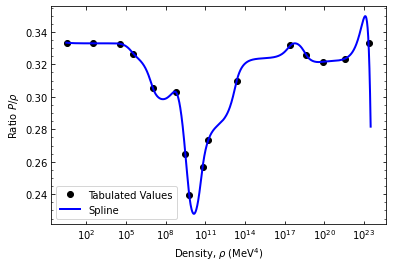

In [112]:
reload(ms_hm.QCD_EOS)
from ms_hm.QCD_EOS import *
QCD_EOS()

Initialized QCD pressure as a function of density.
Initial w is 0.3328789236481935 and Horizon radius is 0.034549414947133546
Not tracing ray and NO excision will be performed!
Horizon was found at step 1590 ! code will be terminated.


-1

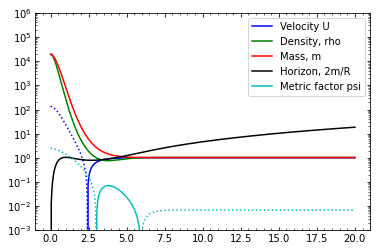

In [11]:
# Reload MS module and try a run
reload(ms_hm.MS)
from ms_hm.MS import *
rho0 = 100 # initial density value in MeV^4
amp = 0.30
ms = MS(Abar, rho0, amp,
        trace_ray=False, BH_threshold=-1, sm_sigma=0.5, plot_interval=-1)

ms.run_steps(40000)

In [50]:
reload(ms_hm.HM)
from ms_hm.HM import *
hm = HM(ms, mOverR=0.99, sm_sigma=15)
hm.adap_run_steps(550000)
print(hm.BH_mass2())

In [ ]:
find_mass(0.30, is_searching_for_crit=False)

In [ ]:
# Call the find_crit function to search for the amplitude required to form a BH
find_crit(0.27, 0.30)

In [171]:
find_mass(0.29957632221281527, is_searching_for_crit=False)

In [14]:
find_mass(0.2728846216201781, is_searching_for_crit=True)

## Simulation Run

Below is an example of all the code needed to find the critical scaling threshhold and exponent.

In [ ]:
# Find the critical point. It will be bounded between crit and lower.
(crit, lower) = find_crit()
# Find the mass of BHs at various amplitudes between lower_amp and lower_amp plus a bit.
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

In [127]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [106]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)